### 0.0 IMPORTS

In [2]:
# Importando todas as bibliotecas utilizadas

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings



### 1.0 LOAD DATA

In [3]:
# Carregamento Dataset do site "http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_01"

df = pd.read_csv('https://github.com/Xicojr/TechChallenge1/raw/main/Dados/ExpVinho.csv',sep=';')

### 1.1 FUNCTIONS

In [ ]:
#Função para formartar o gráfico de barras em Milhões
def milhoes_formatter(x, pos):
    return f'{x / 1e6}M'
warnings.filterwarnings('ignore')


### 2.0 DATA PREPARATION

In [ ]:
# Slip do DF original para extrair apenas os valores em U$
df_valores = df[['Id', 'País'] + [coluna for coluna in df.columns if coluna.endswith('.1')]]

# Slip do DF original para extrair apenas a volumetria em litros
df_litros = df[[coluna for coluna in df.columns if not coluna.endswith('.1')]]

# Aplicando Melt() nos dois df's
df_valores = pd.melt(df_valores, id_vars=['Id','País'], var_name='Ano', value_name='Valor_U$')
df_litros = pd.melt(df_litros, id_vars=['Id','País'], var_name='Ano', value_name='Total_Litros')

#Excluindo o ".1" do DF Valores
df_valores['Ano'] = df_valores['Ano'].str.slice(stop=-2)

# Chave para Merge dos df's
df_valores['key'] =  df_valores['País'] + df_valores['Ano']
df_litros['key'] =  df_litros['País'] + df_litros['Ano']

# Merge
df_merged = pd.merge(df_litros,df_valores,on='key' )


In [ ]:
# Criar Lista para as colunas fixas do df litros

Colunas_Litros = []
for coluna in df.columns:
    if coluna.endswith('.1') or coluna.startswith('Id') or coluna.startswith('País') :
        Colunas_Litros.append(coluna)


# Criar Lista para as colunas fixas do df litros

Colunas_valores = []
for coluna in df.columns:
    if not(coluna.endswith('.1')) :
        Colunas_valores.append(coluna)

# Criar dois df's (litros e valores) e Transformar colunas em linhas
df_litros = pd.melt(df, id_vars=Colunas_Litros, var_name='Ano', value_name='Total_Litros')
df_litros = df_litros[['Id', 'País','Ano','Total_Litros']]

df_valores = pd.melt(df, id_vars=Colunas_valores,var_name='Ano', value_name='Valor')
df_valores = df_valores[['Id', 'País','Ano', 'Valor']]
df_valores['Ano'] = df_valores['Ano'].str[:-2]


# Criar chave para o merge
df_litros['key'] = df_litros['País'] + df_litros['Ano']
df_valores['key'] = df_valores['País'] + df_valores['Ano']


# Juntar as tabelas com os valores e litros do df
df_merged = df_litros.merge(df_valores, on='key', how='right')

df_merged = df_merged.drop(columns=['key', 'Id_y', 'País_y','Ano_y'])
df_merged = df_merged.rename(columns={'Id_x': 'Id','País_x':'País','Ano_x': 'Ano'})

### 3.0 EDA

#### 3.0 EDA

In [ ]:
df_merged['Ano'] = df_merged['Ano'].astype(int)

In [ ]:
df1 = df_merged[df_merged['Ano'] >= 2008]
df1.head()

,Id,País,Ano,Total_Litros,Valor
4864,1,Afeganistão,2008,0,0
4865,2,África do Sul,2008,0,0
4866,3,"Alemanha, República Democrática",2008,265742,429970
4867,4,Angola,2008,25721,71083
4868,5,Anguilla,2008,0,0


#### 3.1 Criação de features

In [ ]:
#Alterando o tipo do Ano e renomeando a coluna país
df1['Ano'] = df1['Ano'].astype(int)
df1['País'] = df1['País'].replace('Alemanha, República Democrática', 'Alemanha')

# DF agrupado pór ANO
aux3 = df1.groupby("Ano").sum().reset_index()
# DF agrupado por País
aux4 = df1.groupby("País").sum().reset_index()

# Criando feature para identificar o valor da tarifa por ano
aux3['Valor_por_litro'] = aux3['Valor'] / aux3['Total_Litros']

# Filtro do TOP 10 com para base de comparação.
top_10_volume = aux4.sort_values('Total_Litros',ascending=False).head(10)
top_10_valor = aux4.sort_values('Valor',ascending=False).head(10)



In [ ]:
# Agrupando por País e Ano e somando os valores de Total_Litros e Valor
df_acumulado = df1.groupby(['País', 'Ano']).agg({'Total_Litros': 'sum', 'Valor': 'sum'}).reset_index()

# Lista de países que você deseja manter
#paises_desejados = ['Brasil', 'EUA', 'Canadá']

# Filtrando o DataFrame para manter apenas as linhas com os países desejados
df_filtrado = df1[df1['País'].isin(top_10_volume['País'].unique())]

df_filtrado

,Id,País,Ano,Total_Litros,Valor
4866,3,Alemanha,2008,265742,429970
4892,29,China,2008,8689,25926
4911,48,Espanha,2008,2942,6834
4912,49,Estados Unidos,2008,443895,804607
4926,63,Haiti,2008,20,20
...,...,...,...,...,...
6731,76,Japão,2022,37324,82208
6751,96,Países Baixos,2022,7034,37240
6753,98,Paraguai,2022,5076670,7156293
6759,104,Reino Unido,2022,18835,138154


#### 3.1.1 Lista País e Continente

In [ ]:
paises_continente = {
    'Afeganistão': 'Ásia',
    'Alemanha': 'Europa',
    'Angola': 'África',
    'Anguilla': 'América do Norte',
    'Antilhas Holandesas': 'América do Norte',
    'Antígua e Barbuda': 'América do Norte',
    'Argentina': 'América do Sul',
    'Aruba': 'América do Norte',
    'Austrália': 'Oceania',
    'Bahamas': 'América do Norte',
    'Bangladesh': 'Ásia',
    'Barbados': 'América do Norte',
    'Barein': 'Ásia',
    'Belice': 'América do Norte',
    'Benin': 'África',
    'Bolívia': 'América do Sul',
    'Brasil': 'América do Sul',
    'Bulgária': 'Europa',
    'Bélgica': 'Europa',
    'Bósnia-Herzegovina': 'Europa',
    'Cabo Verde': 'África',
    'Camarões': 'África',
    'Canadá': 'América do Norte',
    'Catar': 'Ásia',
    'Cayman, Ilhas': 'América do Norte',
    'Chile': 'América do Sul',
    'China': 'Ásia',
    'Chipre': 'Europa',
    'Cingapura': 'Ásia',
    'Cocos (Keeling), Ilhas': 'Oceania',
    'Colômbia': 'América do Sul',
    'Comores': 'África',
    'Congo': 'África',
    'Coreia, Republica Sul': 'Ásia',
    'Costa Rica': 'América do Norte',
    'Costa do Marfim': 'África',
    'Croácia': 'Europa',
    'Cuba': 'América do Norte',
    'Curaçao': 'América do Norte',
    'Dinamarca': 'Europa',
    'Dominica': 'América do Norte',
    'El Salvador': 'América do Norte',
    'Emirados Arabes Unidos': 'Ásia',
    'Equador': 'América do Sul',
    'Eslovaca, Republica': 'Europa',
    'Espanha': 'Europa',
    'Estados Unidos': 'América do Norte',
    'Estônia': 'Europa',
    'Filipinas': 'Ásia',
    'Finlândia': 'Europa',
    'França': 'Europa',
    'Gana': 'África',
    'Gibraltar': 'Europa',
    'Granada': 'América do Norte',
    'Grécia': 'Europa',
    'Guatemala': 'América do Norte',
    'Guiana': 'América do Sul',
    'Guiana Francesa': 'América do Sul',
    'Guine Bissau': 'África',
    'Guine Equatorial': 'África',
    'Haiti': 'América do Norte',
    'Honduras': 'América do Norte',
    'Hong Kong': 'Ásia',
    'Hungria': 'Europa',
    'Ilha de Man': 'Europa',
    'Ilhas Virgens': 'América do Norte',
    'India': 'Ásia',
    'Indonésia': 'Ásia',
    'Iraque': 'Ásia',
    'Irlanda': 'Europa',
    'Irã': 'Ásia',
    'Itália': 'Europa',
    'Jamaica': 'América do Norte',
    'Japão': 'Ásia',
    'Jordânia': 'Ásia',
    'Letônia': 'Europa',
    'Libéria': 'África',
    'Luxemburgo': 'Europa',
    'Líbano': 'Ásia',
    'Malta': 'Europa',
    'Malásia': 'Ásia',
    'Marshall, Ilhas': 'Oceania',
    'Mauritânia': 'África',
    'Montenegro': 'Europa',
    'Moçambique': 'África',
    'México': 'América do Norte',
    'Namibia': 'África',
    'Nicaragua': 'América do Norte',
    'Nigéria': 'África',
    'Noruega': 'Europa',
    'Nova Caledônia': 'Oceania',
    'Nova Zelândia': 'Oceania',
    'Omã': 'Ásia',
    'Panamá': 'América do Norte',
    'Paraguai': 'América do Sul',
    'Países Baixos': 'Europa',
    'Peru': 'América do Sul',
    'Polônia': 'Europa',
    'Porto Rico': 'América do Norte',
    'Portugal': 'Europa',
    'Quênia': 'África',
    'Reino Unido': 'Europa',
    'República Dominicana': 'América do Norte',
    'Rússia': 'Europa/Ásia',
    'Senegal': 'África',
    'Serra Leoa': 'África',
    'Singapura': 'Ásia',
    'Suazilândia': 'África',
    'Suriname': 'América do Sul',
    'Suécia': 'Europa',
    'Suíça': 'Europa',
    'São Tomé e Príncipe': 'África',
    'São Vicente e Granadinas': 'América do Norte',
    'Tailândia': 'Ásia',
    'Taiwan (FORMOSA)': 'Ásia',
    'Tanzânia': 'África',
    'Tcheca, República': 'Europa',
    'Togo': 'África',
    'Trinidade Tobago': 'América do Norte',
    'Tunísia': 'África',
    'Turquia': 'Europa/Ásia',
    'Tuvalu': 'Oceania',
    'Uruguai': 'América do Sul',
    'Vanuatu': 'Oceania',
    'Venezuela': 'América do Sul',
    'Vietnã': 'Ásia',
    'África do Sul': 'África',
    'Áustria': 'Europa'
}



#### 3.1.2 Análise Exploratória

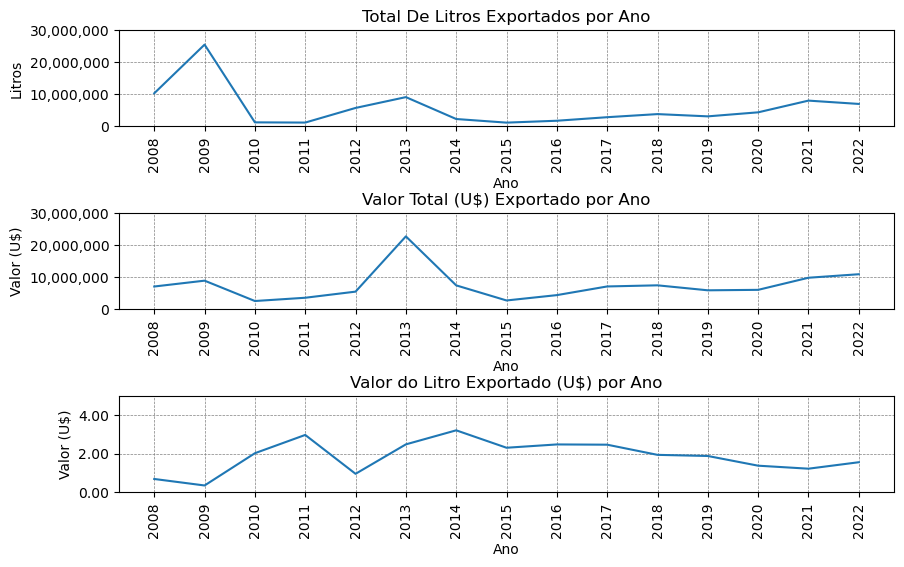

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(3,1,2)
graph = sns.lineplot(x='Ano', y='Valor', data=aux3)
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.ylim(0,30000000)
plt.xlabel('Ano')
plt.ylabel('Valor (U$)')
plt.title("Valor Total (U$) Exportado por Ano")
plt.xticks(aux3['Ano'][::1],rotation=90)

plt.subplot(3,1,1)
graph = sns.lineplot(x='Ano', y='Total_Litros', data=aux3)
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.ylim(0,30000000)
plt.xlabel('Ano')
plt.ylabel('Litros')
plt.title('Total De Litros Exportados por Ano')
plt.xticks(aux3['Ano'][::1],rotation=90)

plt.subplot(3,1,3)
graph = sns.lineplot(x='Ano', y='Valor_por_litro', data=aux3)
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.ylim(0,5.0)
plt.xlabel('Ano')
plt.ylabel('Valor (U$)')
plt.title("Valor do Litro Exportado (U$) por Ano")
plt.xticks(aux3['Ano'][::1],rotation=90)
plt.subplots_adjust(hspace=0.9)

plt.show()



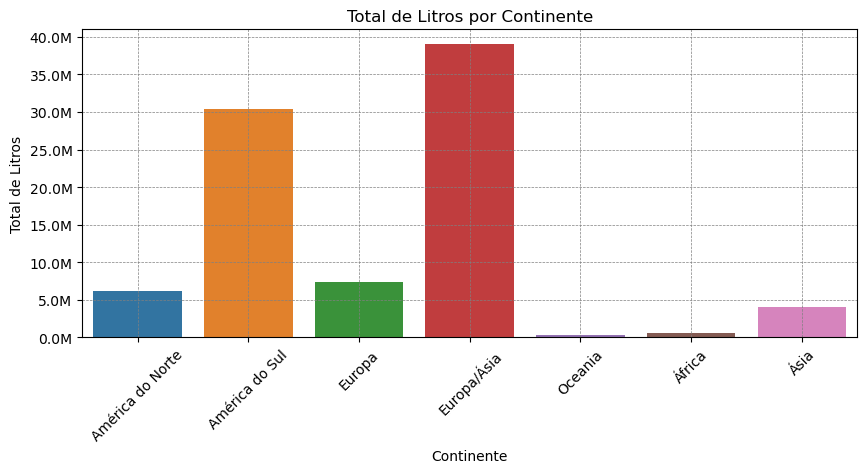

In [ ]:
aux4['Continente'] = aux4['País'].map(paises_continente)

aux5 = aux4.groupby('Continente').sum().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x='Continente', y='Total_Litros', data=aux5)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(milhoes_formatter))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
#plt.yticks(valores_ticks_y)
#plt.ylim(0,27000000)
plt.xlabel('Continente')
plt.ylabel('Total de Litros')
plt.title('Total de Litros por Continente')
plt.xticks(rotation=45)


plt.show()
plt.close()

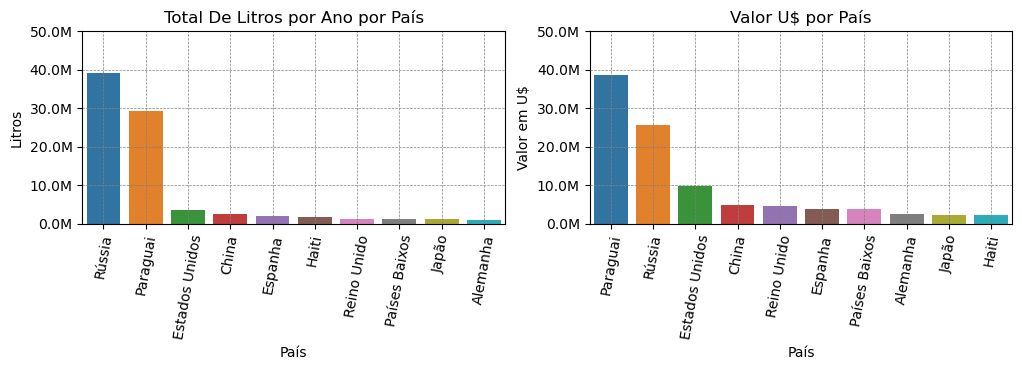

In [ ]:

plt.figure(figsize=(12,8))

# Define o intervalo desejado para o eixo Y
intervalo_y = 10000000  # Intervalo desejado entre os valores no eixo Y
valor_minimo = 0  # Valor mínimo desejado no eixo Y
valor_maximo = 50000000   # Valor máximo desejado no eixo Y
valores_ticks_y = np.arange(valor_minimo, valor_maximo + 1, intervalo_y)

plt.subplot(2,2,2)
graph = sns.barplot(x='País', y='Valor', data=top_10_valor)
#graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(milhoes_formatter))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.yticks(valores_ticks_y)
#plt.ylim(0,27000000)
plt.xlabel('País')
plt.ylabel('Valor em U$')
plt.title('Valor U$ por País')
plt.xticks(rotation=80)

# Define o intervalo desejado para o eixo Y
intervalo_y1 = 10000000  # Intervalo desejado entre os valores no eixo Y
valor_minimo1 = 0  # Valor mínimo desejado no eixo Y
valor_maximo1 = 50000000   # Valor máximo desejado no eixo Y
valores_ticks_y1 = np.arange(valor_minimo1, valor_maximo1 + 1, intervalo_y1)

plt.subplot(2,2,1)
graph = sns.barplot(x='País', y='Total_Litros', data=top_10_volume)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(milhoes_formatter))
#graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.yticks(valores_ticks_y1)
plt.xlabel('País')
plt.ylabel('Litros')
plt.title('Total De Litros por Ano por País')
plt.xticks(rotation=80)

plt.subplots_adjust(hspace=1.2)

plt.show()


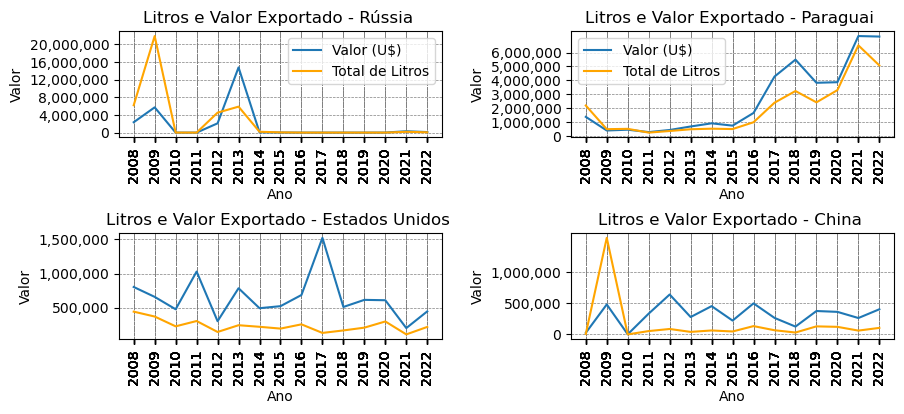

In [ ]:
plt.figure(figsize=(10, 4))  # Define o tamanho da figura

## RUSSIA

intervalo_1 = 4000000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_1 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_1 = 400000000   # Valor máximo desejado no eixo Y
valores_ticks_1 = np.arange(valor_minimo_1, valor_maximo_1 + 1, intervalo_1)
plt.subplot(2, 2, 1)
# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Rússia'], label='Valor (U$)')
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_1)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Rússia'], color='orange', label='Total de Litros')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Rússia ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)

#-----------------------------------------------------##---------------------------------------------------------------
## PARAGUAI

intervalo_2 = 1000000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_2 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_2 = 6000000   # Valor máximo desejado no eixo Y
valores_ticks_2 = np.arange(valor_minimo_2, valor_maximo_2 + 1, intervalo_2)
plt.subplot(2, 2, 2)
# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Paraguai'], label='Valor (U$)')
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_2)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Paraguai'], color='orange', label='Total de Litros')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Paraguai ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)

#-----------------------------------------------------##---------------------------------------------------------------
## ESTADOS UNIDOS

intervalo_3 = 500000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_3 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_3 = 2000000   # Valor máximo desejado no eixo Y
valores_ticks_3 = np.arange(valor_minimo_3, valor_maximo_3 + 1, intervalo_3)
plt.subplot(2, 2, 3)
# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Estados Unidos'])
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_3)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Estados Unidos'], color='orange')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Estados Unidos ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)

#-----------------------------------------------------##---------------------------------------------------------------
## CHINA

intervalo_3 = 500000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_3 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_3 = 1000000   # Valor máximo desejado no eixo Y
valores_ticks_3 = np.arange(valor_minimo_3, valor_maximo_3 + 1, intervalo_3)
plt.subplot(2, 2, 4)
# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'China'])
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_3)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'China'], color='orange')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - China ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)



plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.9)
plt.show()


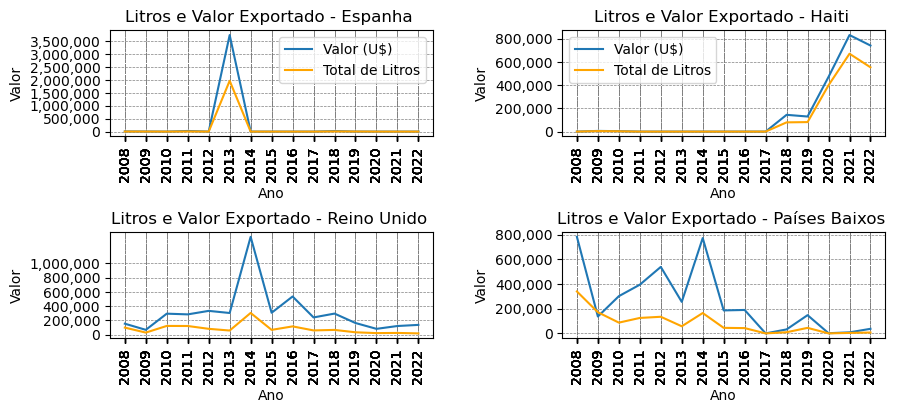

In [ ]:
#-----------------------------------------------------##---------------------------------------------------------------
plt.figure(figsize=(10, 4))  # Define o tamanho da figura

## ESPANHA

intervalo_4 = 500000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_4 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_4 = 5000000   # Valor máximo desejado no eixo Y
valores_ticks_4 = np.arange(valor_minimo_4, valor_maximo_4 + 1, intervalo_4)

plt.subplot(2, 2, 1)
# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Espanha'], label='Valor (U$)')
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_4)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Espanha'], color='orange', label='Total de Litros')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Espanha ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)

#-----------------------------------------------------##---------------------------------------------------------------
## HAITI
intervalo_5 = 200000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_5 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_5 = 1000000   # Valor máximo desejado no eixo Y
valores_ticks_5 = np.arange(valor_minimo_5, valor_maximo_5 + 1, intervalo_5)

plt.subplot(2, 2, 2)

# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Haiti'], label='Valor (U$)')
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_5)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Haiti'], color='orange', label='Total de Litros')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Haiti ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)

#-----------------------------------------------------##---------------------------------------------------------------
## Reino Unido
intervalo_5 = 200000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_5 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_5 = 1000000   # Valor máximo desejado no eixo Y
valores_ticks_5 = np.arange(valor_minimo_5, valor_maximo_5 + 1, intervalo_5)

plt.subplot(2, 2, 3)

# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Reino Unido'])
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_5)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Reino Unido'], color='orange')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Reino Unido ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)

#-----------------------------------------------------##---------------------------------------------------------------
## Paises Baixos
intervalo_5 = 200000  # Intervalo desejado entre os valores no eixo Y
valor_minimo_5 = 0  # Valor mínimo desejado no eixo Y
valor_maximo_5 = 2000000   # Valor máximo desejado no eixo Y
valores_ticks_5 = np.arange(valor_minimo_5, valor_maximo_5 + 1, intervalo_5)

plt.subplot(2, 2, 4)

# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Países Baixos'])
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_5)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Países Baixos'], color='orange')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Países Baixos ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)


plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.9)
plt.show()


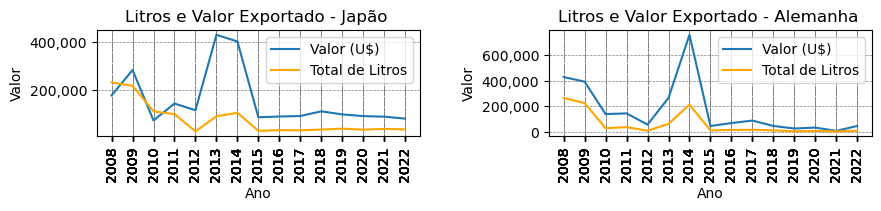

In [ ]:
#-----------------------------------------------------##---------------------------------------------------------------

plt.figure(figsize=(10, 4))

## JAPÃO
plt.subplot(2, 2, 1)
# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Japão'], label='Valor (U$)')
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_5)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Japão'], color='orange', label='Total de Litros')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Japão ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)

#-----------------------------------------------------##---------------------------------------------------------------
## ALEMANHA

plt.subplot(2, 2, 2)
# Crie o gráfico de linha para 'Valor'
graph = sns.lineplot(x='Ano', y='Valor', data=df_filtrado[df_filtrado['País'] == 'Alemanha'], label='Valor (U$)')
graph.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.yticks(valores_ticks_5)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adicione o gráfico de linha para 'Total de Litros' ao mesmo eixo
sns.lineplot(x='Ano', y='Total_Litros', data=df_filtrado[df_filtrado['País'] == 'Alemanha'], color='orange', label='Total de Litros')
plt.xlabel('Ano')
plt.title("Litros e Valor Exportado - Alemanha ")
plt.xticks(df_filtrado['Ano'][::1], rotation=90)


plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.9)
plt.show()